# Apple length traj 300

I'm done with naming notebooks!!!

In [28]:
import numpy as np 
from matplotlib import pyplot as plt
from scipy.stats import norm

np.random.seed(69696969)

# Data Generation from Wiener Velocity Profile

Because this is the simplest case!

Text(0.5, 1.0, 'Position Profiles')

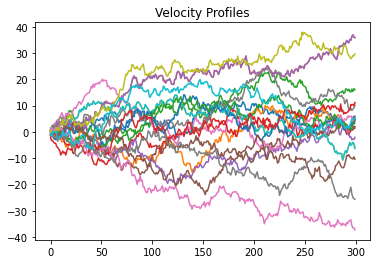

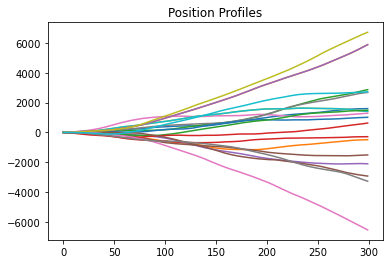

In [29]:
num_of_trajs = 200
length_of_trajs = 300
v_profiles = np.zeros((num_of_trajs, length_of_trajs))
x_profiles = np.zeros((num_of_trajs, length_of_trajs))
for i in range(num_of_trajs):
    a_profile = norm.rvs(scale=1, size=length_of_trajs)
    v_profiles[i,:] = np.cumsum(a_profile)
    x_profiles[i,:] = np.cumsum(v_profiles[i,:])
# Plot some sample v profiles and x profiles
trajs_to_plot = np.random.choice(num_of_trajs, 20)
plt.figure()
for i in trajs_to_plot:
    plt.plot(v_profiles[i,:])
plt.title('Velocity Profiles')
plt.figure()
for i in trajs_to_plot:
    plt.plot(x_profiles[i,:])
plt.title('Position Profiles')

# Find the Numerical FPCA

And let's call this basis NECTARINE.

In [30]:
import skfda
from skfda.preprocessing.dim_reduction.projection import FPCA

Text(0.5, 1.0, 'Numerical FPCA basis of Position Profiles')

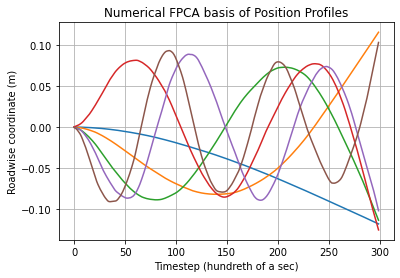

In [31]:
fdgrx = skfda.FDataGrid(x_profiles, np.arange(x_profiles.shape[1]))
fdgrv = skfda.FDataGrid(x_profiles, np.arange(x_profiles.shape[1]))
fpcax = FPCA(n_components=6)
fpcax.fit(fdgrx)
fpcax.components_.plot()
plt.xlabel('Timestep (hundreth of a sec)')
plt.ylabel('Roadwise coordinate (m)')
plt.grid(True)
plt.title('Numerical FPCA basis of Position Profiles')

Get the covariance matrix, eigenvalues and eigenvectors

In [32]:
covx = fdgrx.cov().data_matrix
covx = covx.reshape(covx.shape[1:3])
evalx, evecx = np.linalg.eig(covx)
evalx = np.real(evalx)

Text(0.5, 1.0, 'Covariance matrix illustration')

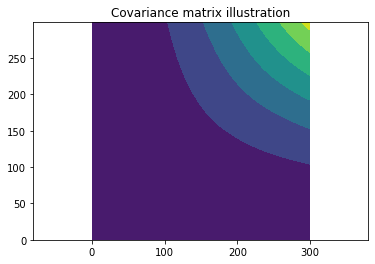

In [33]:
plt.contourf(covx)
plt.axis('equal')
plt.title('Covariance matrix illustration')

The eigenvalues ratio of x:

[9.71294093e-01 2.39637816e-02 3.20618863e-03 8.99099822e-04
 3.00676242e-04]


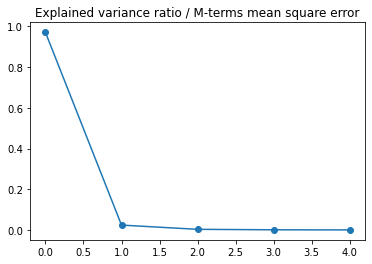

In [34]:
plt.plot(evalx[:5]/np.sum(evalx), '-o')
plt.title('Explained variance ratio / M-terms mean square error')
print(evalx[:5]/np.sum(evalx))

# Approximation of the Wiener process and its Integration

First we confirm the expansion of the Wiener process: $v(t) = \sum A_k \sqrt{2} cos((k-\frac{1}{2}\pi t))$ where $A_k$ follows a Gaussian random variable with variance $\frac{1}{((k-1/2)\pi)^2}$.

Text(0.5, 1.0, 'Reconstructed velocity profiles from 100 terms of expansion\nWithout restriction of time')

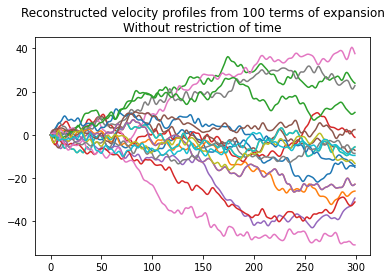

In [35]:
wiener = np.zeros((num_of_trajs, length_of_trajs))
wiener_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
for k in range(wiener_terms):
    for i in range(num_of_trajs):
        Ak = norm.rvs(scale=1/((k+0.5)*np.pi))
        wiener[i,:] += np.sqrt(length_of_trajs) * Ak * np.sqrt(2) * np.sin((k+0.5)*np.pi*t)
for i in trajs_to_plot:
    plt.plot(wiener[i,:])
plt.title('Reconstructed velocity profiles from {:d} terms of expansion\nWithout restriction of time'.format(wiener_terms))

Compare this with the Wiener velocity profiles above, we confirm the expansion of Wiener process by sine functions. Now let us restrict $t$ to $[0,1]$, without any loss of generality. As a result, we don't have to multiply each term with $\sqrt{N}$ - the length of the trajectory.

Text(0.5, 1.0, 'Reconstructed velocity profiles from 100 terms of expansion\nWith time restricted to [0,1]')

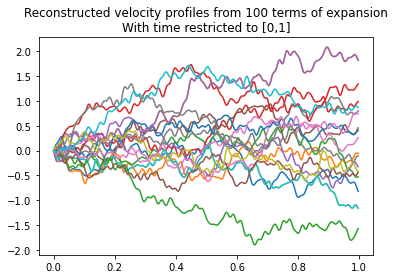

In [36]:
wiener = np.zeros((num_of_trajs, length_of_trajs))
wiener_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
for k in range(wiener_terms):
    for i in range(num_of_trajs):
        Ak = norm.rvs(scale=1/((k+0.5)*np.pi))
        wiener[i,:] += Ak * np.sqrt(2) * np.sin((k+0.5)*np.pi*t)
for i in trajs_to_plot:
    plt.plot(t, wiener[i,:])
plt.title('Reconstructed velocity profiles from {:d} terms of expansion\nWith time restricted to [0,1]'.format(wiener_terms))

We will try to construct the position profiles from $A_k$ and cosine: $x(t) = \sum_{k=1}^{+\infty} \frac{-\sqrt{2} A_k}{(k-1/2)\pi} (cos ((k-1/2)\pi t)-1)$.

Text(0.5, 1.0, 'Reconstructed position profiles from 100 terms of expansion\nWith time restricted to [0,1]')

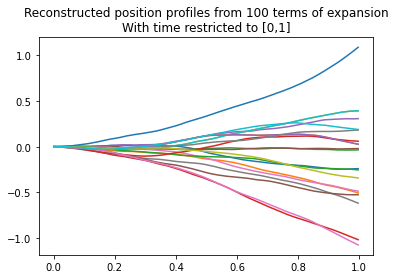

In [37]:
wienerint = np.zeros((num_of_trajs, length_of_trajs))
wienerint_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
# Generate Ak and Lambda
Ak = np.zeros((num_of_trajs, wienerint_terms))
Lamda = np.zeros((num_of_trajs,))
for k in range(wienerint_terms):
    for i in range(num_of_trajs):
        Ak[i,k] = norm.rvs(scale=1/((k+0.5)*np.pi))
        Lamda[i] += np.sqrt(2) * Ak[i,k] / ((k+0.5) * np.pi)
# Construct the position profiles
for i in range(num_of_trajs):
    for k in range(wienerint_terms):
        Aks = Ak[i,k]
        Lambd = Lamda[i]
        # wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi)) + (-1)**(k) * Lambd * 4./(np.pi * (2*k+1)) * np.cos((k+0.5)*np.pi*t)
        wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi)) * (np.cos((k+0.5)*np.pi*t)-1)
for i in trajs_to_plot:
    plt.plot(t, wienerint[i,:])
plt.title('Reconstructed position profiles from {:d} terms of expansion\nWith time restricted to [0,1]'.format(wiener_terms))

Reconstruction of $1(t)$ in the odd cosine basis:

Text(0.5, 1.0, 'Expansion of $1(t)$ in 10 terms')

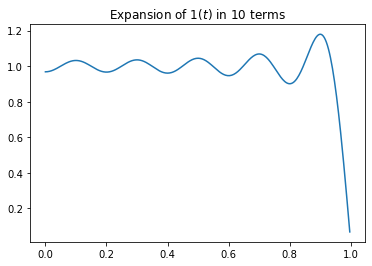

In [38]:
one_t = np.zeros((length_of_trajs))
one_terms = 10
t = np.arange(length_of_trajs)/length_of_trajs
for k in range(one_terms):
    one_t += 4/(np.pi) * 1/(2*k + 1) * ((-1)**k) * (np.cos((k+0.5)*np.pi*t))
plt.plot(t, one_t)
plt.title("Expansion of $1(t)$ in {:d} terms".format(one_terms))

So the expansion seems correct, but note the strong attenuation near $t=1$.

Which will also be equal to:

$ = \sum_{k=1}^{+\infty} \left( \frac{-\sqrt{2} A_k}{(k-1/2)\pi} + (-1)^{k+1} \Lambda \frac{4}{\pi} \frac{1}{2k-1} \right) cos ((k-1/2)\pi t)$ 

Text(0.5, 1.0, 'Reconstructed position profiles from 100 terms of expansion\nWith time restricted to [0,1]')

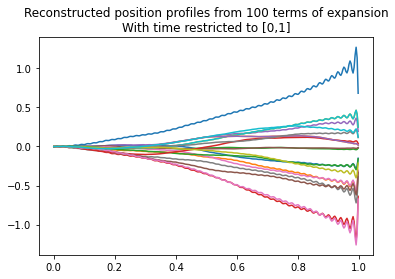

In [39]:
wienerint = np.zeros((num_of_trajs, length_of_trajs))
wienerint_terms = 100
t = np.arange(length_of_trajs)/length_of_trajs
# Generate Ak and Lambda
# Ak = np.zeros((num_of_trajs, wienerint_terms))
Lamda = np.zeros((num_of_trajs,))
for k in range(wienerint_terms):
    for i in range(num_of_trajs):
        # Ak[i,k] = norm.rvs(scale=1/((k+0.5)*np.pi)) # i: traj index, k: component index
        Lamda[i] += np.sqrt(2) * Ak[i,k] / ((k+0.5) * np.pi)
# Construct the position profiles
for i in range(num_of_trajs):
    for k in range(wienerint_terms):
        Aks = Ak[i,k]
        Lambd = Lamda[i]
        wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi) + (-1)**(k) * Lambd * 4./(np.pi * (2*k+1))) * np.cos((k+0.5)*np.pi*t)
        # wienerint[i,:] += (-np.sqrt(2) * Aks / ((k+0.5)*np.pi)) * (np.cos((k+0.5)*np.pi*t)-1)
for i in trajs_to_plot:
    plt.plot(t, wienerint[i,:])
plt.title('Reconstructed position profiles from {:d} terms of expansion\nWith time restricted to [0,1]'.format(wiener_terms))

It seems that the approximation works, but we don't know for sure whether the approximation is reasonable. 

# The Transform Coefficient Covariance Matrix

Next, we verify the formula for the covariance matrix of the Transform Coefficient Covariance. We hope that this covariance matrix, when stripped off the off-diagonal elements, will reasonably approximate the covariance matrix, which yields hope that the KLT and OCT are asymptotically equivalent.

### **Numerical** approximation of the TCV:

In [40]:
CNcn = np.zeros((wienerint_terms, wienerint_terms))
for k in range(wienerint_terms):
    for s in range(wienerint_terms):
        coeffs_k = (-np.sqrt(2) * Ak[:,k] / ((k+0.5)*np.pi) + (-1)**(k) * Lambd * 4./(np.pi * (2*k+1)))
        coeffs_s = (-np.sqrt(2) * Ak[:,s] / ((s+0.5)*np.pi) + (-1)**(s) * Lambd * 4./(np.pi * (2*s+1)))
        # coeffs_s = np.random.permutation(coeffs_s)
        CNcn[k,s] = np.average(coeffs_k * coeffs_s)

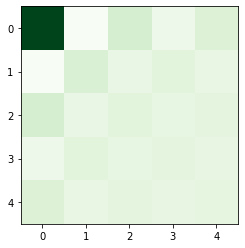

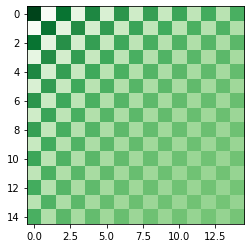

In [41]:
plt.figure()
plt.imshow(CNcn[:5,:5], cmap='Greens')
plt.figure()
plt.imshow(CNcn[5:20,5:20], cmap='Greens')

### **Analytical** formular for the TCV:

In [42]:
def delta(n,m):
    return 1 if n==m else 0

In [43]:
fourth_order_term = 0
for i in range(wienerint_terms):
    fourth_order_term += 1/((i+0.5)**4)
print('Fourth order term converges to {}'.format(fourth_order_term))

Fourth order term converges to 16.234848172350404


In [44]:
CNc = np.zeros((wienerint_terms, wienerint_terms))
for n in range(wienerint_terms):
    for m in range(wienerint_terms):
        # Note that we have discarded the fourth order term. 
        CNc[n,m] = 1/(((np.pi)**2) * (n+0.5) * (m+0.5)) * ((1 * delta(n,m) / (((np.pi)**2) * ((n+0.5)**2))) + (4 * (-1)**(m+1) / ((np.pi**4) * fourth_order_term))  + 2 * (((-1)**(m)) / (((np.pi)**3) * ((n+0.5)**3)) + ((-1)**(n)) / (((np.pi)**3) * ((m+0.5)**3))))

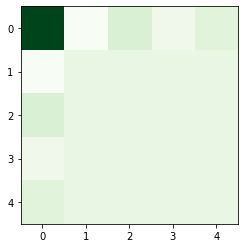

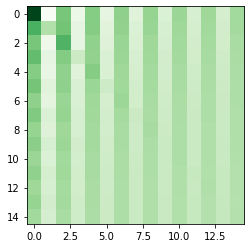

In [45]:
plt.figure()
plt.imshow(CNc[:5,:5], cmap='Greens')
plt.figure()
plt.imshow(CNc[5:20,5:20], cmap='Greens')

In [46]:
CNc[:5,:5]

array([[ 5.81504348e-01, -6.67886494e-02,  4.19569707e-02,
        -2.96431471e-02,  2.31554045e-02],
       [-6.74720593e-02,  4.20458857e-04,  3.36506687e-04,
        -3.49067799e-04,  2.38289386e-04],
       [ 4.19569707e-02,  4.73188664e-04,  3.55652151e-04,
        -1.09290472e-06,  2.07747114e-05],
       [-2.99360371e-02, -3.49067799e-04, -5.96708948e-05,
         6.44452104e-05, -1.11471141e-05],
       [ 2.31554045e-02,  3.14223818e-04,  2.07747114e-05,
         2.13962137e-05,  1.94629288e-05]])

In [47]:
CNcn[:5,:5]

array([[ 0.43561109, -0.05880105,  0.03574811, -0.02604815,  0.02019348],
       [-0.05880105,  0.02426719, -0.01249853,  0.00877704, -0.007016  ],
       [ 0.03574811, -0.01249853,  0.00794717, -0.00529579,  0.00420431],
       [-0.02604815,  0.00877704, -0.00529579,  0.00388055, -0.00298313],
       [ 0.02019348, -0.007016  ,  0.00420431, -0.00298313,  0.00242749]])

In essence, the top-left elements of the covariance matrix dominates rather than the main-diagonal. Hence, because of the presence of $\Lambda$, the main diagonal won't dominate all off-diagonal elements. Without $\Lambda$, it is easy to conclude that the OCT coincides with the KLT.

# Asymptotic Equivalence between OCT and KLT

The proof shows OCT and KLT should be equivalent when the block size $N$ is large (i.e., time range is wide). We will verify this experimentally.

Text(0.5, 1.0, 'OCT basis')

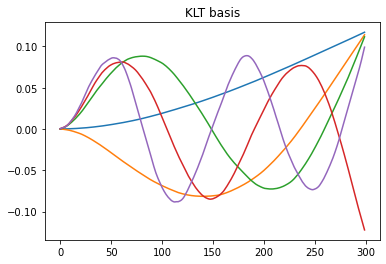

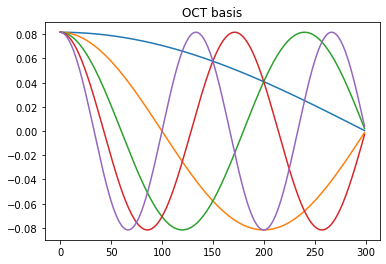

In [48]:
klt_basis = np.real(evecx.T) # each row is now an eigenvector
t = np.arange(length_of_trajs)/length_of_trajs
oct_basis = np.zeros(klt_basis.shape)
for i in range(klt_basis.shape[0]):
    oct_basis[i,:] = np.sqrt(2/(length_of_trajs)) * np.cos((i+0.5)*np.pi*t)
plt.figure()
for i in range(5):
    plt.plot(klt_basis[i,:])
plt.title('KLT basis')
plt.figure()
for i in range(5):
    plt.plot(oct_basis[i,:])
plt.title('OCT basis')

Let's approximate the average error when representing 100 trajectories in each basis: KLT and OCT

In [49]:
chosen_trajs = np.random.choice(num_of_trajs, size=100)
test_set = x_profiles[chosen_trajs,:]
klt_scores = test_set @ klt_basis.T
oct_scores = test_set @ oct_basis.T 

First we should check to make sure that the signal energy is well preserved in both basis.

In [50]:
signal_energy = np.sum(np.square(test_set), axis=1)
print('Max difference between KLT coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(klt_scores), axis=1) - np.sum(np.square(test_set), axis=1))))
print('Max difference between OCT coeffs energy and signal energy: {}'.format(np.max(np.sum(np.square(oct_scores), axis=1) - np.sum(np.square(test_set), axis=1))))

Max difference between KLT coeffs energy and signal energy: -0.07031059265136719
Max difference between OCT coeffs energy and signal energy: 6.962396085262299


Next, we try to compare the average approximation error with 1, 2, 3, ... components allowed to represent.

In [51]:
representation_error_of_klt = np.ones((10,))
representation_error_of_oct = np.ones((10,))
for max_components_allowed in range(1,10):
    tail_of_signal_klt = test_set - klt_scores[:,:max_components_allowed] @ klt_basis[:max_components_allowed,:]
    energy_of_signal_tail_klt = np.sum(np.square(tail_of_signal_klt), axis=1)
    proportion_of_energy_klt = energy_of_signal_tail_klt / signal_energy
    representation_error_of_klt[max_components_allowed] = np.average(proportion_of_energy_klt)

    tail_of_signal_oct = test_set - oct_scores[:,:max_components_allowed] @ oct_basis[:max_components_allowed,:]
    energy_of_signal_tail_oct = np.sum(np.square(tail_of_signal_oct), axis=1)
    proportion_of_energy_oct = energy_of_signal_tail_oct / signal_energy
    representation_error_of_oct[max_components_allowed] = np.average(proportion_of_energy_oct)

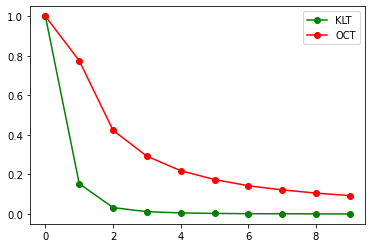

In [52]:
plt.plot(np.arange(0,10), representation_error_of_klt, 'g-o', label='KLT')
plt.plot(np.arange(0,10), representation_error_of_oct, 'r-o', label='OCT')
plt.legend()

In [53]:
representation_error_of_oct

array([1.        , 0.77520779, 0.42329904, 0.29252635, 0.21887117,
       0.17444415, 0.14288046, 0.1219765 , 0.10581271, 0.09309576])

In [54]:
representation_error_of_klt

array([1.00000000e+00, 1.53370735e-01, 3.24769350e-02, 1.18118932e-02,
       5.65381213e-03, 2.93848211e-03, 1.67318231e-03, 1.21724097e-03,
       6.38731778e-04, 4.65155641e-04])